# Mushroom (LIBSVM) optimizer comparison


## 1. Task Description

Binary classification on the LIBSVM mushrooms dataset (categorical features expanded to a high-dimensional real vector via the LIBSVM format). Labels are mapped to $\{0; 1\}$

### Objective

Empirical risk minimization with cross-entropy:
$$
\min_\theta f(\theta)=\frac{1}{n}\sum_{i=1}^n\ell(\theta;x_i,y_i)
$$
where $\ell$ is cross entropy for a 2-clas classifier

### Model

Training classifier is a 2-layer ReLU network (`hidden_dim > 0`)
```python
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=10, output_dim=2, 
                 weight_init="uniform", dtype=None, bias=True):
        super(LinearClassifier, self).__init__()
        if hidden_dim > 0:
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim, dtype=dtype, bias=bias),
                # nn.Dropout(p=0.1),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim, dtype=dtype, bias=bias),
                nn.Softmax(dim=1),
            )
# ...
```

**Key property**: The objective is non-convex and only $L$-smooth if there is no value dropped below 0, due to ReLU. However, it is differentiable almost everywhere.

### Dataset preprocessing

Dataset is splitted into train/val/test with the ratio 7:2:1.

While `--scale` is being raised, we apply a diagonal feature scaling:
$$
\tilde x=x\cdot\text{diag}(e),\quad e_i=\exp(a_i),\,a_i\sim\text{Uniform}[-k,k]
$$
This is intended to test invariance / robustness to feature scaling and the resulting conditioning changes. This transformation can dramatically change the Lipschitz constant $L$, gradient anisotropy, and effective conditioning—hence it is a strong stress test for first-order methods.
```python
def libsvm_prepocess(args):
    g, seed_worker = utils.set_global_seed(args.seed)
    if args.dataset == "mushrooms":
        if not os.path.exists(f"./{args.data_path}/mushrooms"):
            os.system(f"cd ./{args.data_path}\n wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms \n cd ..")
        X, y = load_svmlight_file(f"./{args.data_path}/mushrooms")
        y = y - 1
        X = X.toarray()
# ...
    
    if args.scale:
        A = np.diag(np.exp(np.random.uniform(-args.scale_bound, args.scale_bound, X.shape[1])))
        X = X @ A
# ...
```


## 2. Optimization methods

### 2.1. Normalized SGD
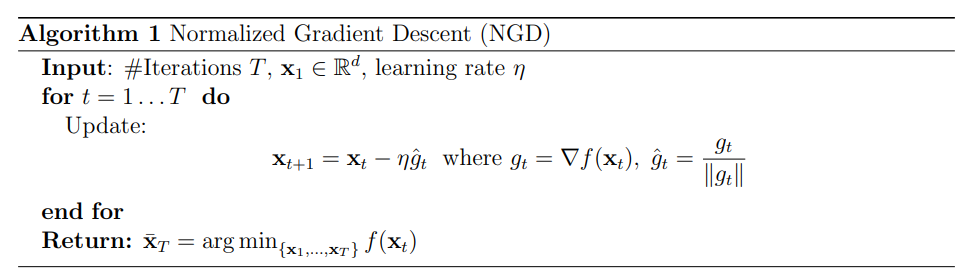

Under $L$-smooth assumption, the convergence rate of NGD is $\mathcal O(1/\sqrt{N})$
```python
class NormalizedSGD(Optimizer):
    """
    Normalized SGD (Frobenius base norm).
    Update direction is -g / ||g|| (per-parameter tensor).
    Optional momentum.
    """
    def __init__(self, params, lr=1e-3, momentum=0.0, weight_decay=0.0, eps=1e-12):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            mu = group["momentum"]
            wd = group["weight_decay"]
            eps = group["eps"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad

                if wd != 0.0:
                    g = g.add(p, alpha=wd)

                state = self.state[p]
                if mu != 0.0:
                    buf = state.get("momentum_buffer", None)
                    if buf is None:
                        buf = state["momentum_buffer"] = torch.zeros_like(g)
                    buf.mul_(mu).add_(g)
                    g_eff = buf
                else:
                    g_eff = g

                # normalized direction
                direction = -g_eff / (torch.norm(g_eff) + eps)
                p.add_(direction, alpha=lr)

        return loss
```

### 2.2. SignSGD
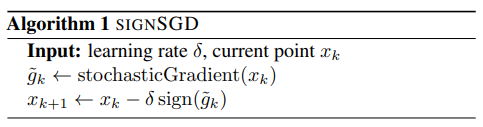

**Theorem** (Non-convex convergence rate of SignSGD) Set the learning rate and mini-batch size (independently of step $k$) as
$$
\delta_k=\frac{1}{\sqrt{\Vert L\Vert_1 K}},\quad n_k=K
$$
where $L:=[L_1,...,L_d]$ is a vector of non-negative constants such that:
$$
\left|f(y)-\left[f(x)+\nabla f(x)^T(y-x)\right]\right|\leq\frac{1}{2}\sum_iL_i(y_i-x_i)^2
$$
Let N be the cummulative number of stochastic gradient calls up to step $K$, i.e. $N=\mathcal O(K^2)$. Then we have
$$
\mathbb E\left[\frac{1}{K}\sum_{k=0}^{K-1}\Vert g_k\Vert_1\right]^2\leq\frac{1}{\sqrt N}\left[\sqrt{\Vert L\Vert_1}\left(f_0-f_*+\frac{1}{2}\right)+2\Vert\sigma\Vert_1\right]^2
$$
where $\sigma=(\sigma_1,...,\sigma_d)$ is a vector of non-negative constants such that the stochastic gradient oracle gives us an independent unbiased estimate $\tilde g$ that has coordinate bounded variance:
$$
\mathbb E[\tilde g(x)]=g(x),\quad \mathbb E[(\tilde g(x)_i-g(x)_i)^2]\leq\sigma_i^2
$$
The number of gradient calls N is the important quantity to measure convergence, but large batch training achieves $N$ gradient calls in only $\mathcal O(\sqrt N)$ iterations whereas small batch training needs $\mathcal O(N)$ iterations. Also, when gradients are dense, SignSGD should be more robust to large stochasticity on a sparse set of coordinates. When gradients are sparse, SGD should be more robust to dense curvature and noise. In practice for deep networks, it is found that SignSGD
converges about as fast as SGD. 
```python
class SignSGD(Optimizer):
    """
    SignSGD (l1 -> linf base norm in practice).
    Optional momentum on raw gradients.
    """
    def __init__(self, params, lr=1e-3, momentum=0.0, weight_decay=0.0):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            mu = group["momentum"]
            wd = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad

                if wd != 0.0:
                    g = g.add(p, alpha=wd)

                state = self.state[p]
                if mu != 0.0:
                    buf = state.get("momentum_buffer", None)
                    if buf is None:
                        buf = state["momentum_buffer"] = torch.zeros_like(g)
                    buf.mul_(mu).add_(g)
                    g_eff = buf
                else:
                    g_eff = g

                p.add_(torch.sign(g_eff), alpha=-lr)

        return loss
```

### 2.3. K-FAC
K-FAC is an efficient approximation to natural gradient descent. Natural gradient replaces the raw gradient $g=\nabla_\theta f(\theta)$ with a curvature-aware direction
$$
\nabla^2\theta=F(\theta)^{-1}g
$$
where $F(\theta)$ is typically the Fisher information matrix (or closely related generalized Gauss–Newton matrix in common settings). The obstacle is that $F$ is enormous (millions of parameters), so forming or inverting it directly is infeasible.

K-FAC makes two structural approximations that make the inverse cheap while still capturing important non-diagonal curvature:
1. Block-diagonal across layers.
Assume gradients from different layers are weakly correlated, so $F$ is approximated as block-diagonal with one block per layer.
2. Kronecker factorization within each layer block.
For a fully-connected layer with weights $W_l$, the Fisher block for $\text{vec}(W_l)$ is approximated as
$$
F_l\approx\Theta_{l-1}\otimes\Gamma_l
$$
where $\Theta_{l-1}\approx\mathbb E[a_{l-1}a_{l-1}^T]$ is an activation covariance factor, and $\Gamma_l\approx\mathbb E[s_ls_l^T]$ is a backprop/preactivation-derivative covariance factor,
and the key modeling step is treating activations and backprop signals as approximately independent, enabling the Kronecker decomposition.

Using this, the “natural-gradient-like” solve becomes a pair of small matrix inversions per layer:
$$
F_l^{-1}\text{vec}(g_l)=\text{vec}(\Gamma_l^{-1}G_l\Theta_{l-1}^{-1})
$$
where $G_l$ is the gradient reshaped as a matrix. This is why K-FAC can be only “a few times” more expensive than SGD per step yet much more curvature-aware.

**Pseudocode summary**
```
Given W, gradient G_t (reshaped as m×n)
Initialize A=0_{m×m}, B=0_{n×n}, A_inv4=I, B_inv4=I

for t = 1,2,...
    W ← (1 − ηλ) W                          # decoupled weight decay

    outerA ← G_t G_t^T
    outerB ← G_t^T G_t

    A ← β A + (1−β) outerA                    # EMA (reduce noise)
    B ← β B + (1−β) outerB

    if t mod update_freq == 0:                # reduce expensive computation of inv. matrix
        A_inv4 ← (A + εI)^(-1/4)
        B_inv4 ← (B + εI)^(-1/4)

    U ← A_inv4 G_t B_inv4                     # preconditioned gradient
    W ← W − ηU

```

```python
class _KroneckerBase(Optimizer):
    """
    Shared machinery for KFAC/Shampoo/OneSided/KL-Shampoo.
    Applies to 2D parameters; other tensors fall back to Adam by default.
    """
    def __init__(
        self,
        params,
        lr=1e-3,
        weight_decay=0.0,
        eps=1e-8,
        update_freq: int = 1,
        beta: float = -1.0,  # beta<0 => sum; beta in [0,1) => EMA
        max_rows: int = 10000,
        fallback_adam: bool = True,
        adam_betas=(0.9, 0.999),
    ):
        defaults = dict(
            lr=lr, weight_decay=weight_decay, eps=eps, update_freq=update_freq,
            beta=beta, max_rows=max_rows, fallback_adam=fallback_adam, adam_betas=adam_betas
        )
        super().__init__(params, defaults)

        # Create a fallback diagonal optimizer for non-matrix params if requested
        self._fallback = None
        if fallback_adam:
            self._fallback = AdamTable1(params, lr=lr, betas=adam_betas, eps=eps, weight_decay=weight_decay)

    def _should_matrix(self, p: torch.Tensor, group) -> bool:
        return _use_matrix_rules(p, max_rows=group["max_rows"])

    def _fallback_step(self):
        if self._fallback is not None:
            self._fallback.step()

class KFAC(_KroneckerBase):
    """
    KFAC: A_t = sum G G^T ; B_t = sum G^T G
    update: A^{-1/4} G B^{-1/4}
    beta in [0,1)
    """
    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        any_fallback = False

        for group in self.param_groups:
            lr = group["lr"]
            wd = group["weight_decay"]
            eps = group["eps"]
            beta = group["beta"]
            update_freq = max(1, int(group["update_freq"]))

            for p in group["params"]:
                if p.grad is None:
                    continue
                if not self._should_matrix(p, group):
                    any_fallback = True
                    continue

                Gm, shp = _as_matrix(p.grad)

                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    m, n = Gm.shape
                    state["A"] = torch.zeros((m, m), device=Gm.device, dtype=Gm.dtype)
                    state["B"] = torch.zeros((n, n), device=Gm.device, dtype=Gm.dtype)
                    state["A_inv4"] = torch.eye(m, device=Gm.device, dtype=Gm.dtype)
                    state["B_inv4"] = torch.eye(n, device=Gm.device, dtype=Gm.dtype)

                state["step"] += 1
                t = state["step"]

                # decoupled WD
                if wd != 0.0:
                    p.mul_(1.0 - lr * wd)

                A = state["A"]
                B = state["B"]

                outerA = Gm @ Gm.T
                outerB = Gm.T @ Gm

                if beta is not None and beta >= 0.0:
                    A.lerp_(outerA, 1.0 - beta)
                    B.lerp_(outerB, 1.0 - beta)
                else:
                    A.add_(outerA)
                    B.add_(outerB)

                if (t % update_freq) == 0:
                    state["A_inv4"] = _inv_root_psd(A, root=4.0, eps=eps)
                    state["B_inv4"] = _inv_root_psd(B, root=4.0, eps=eps)

                A_inv4 = state["A_inv4"]
                B_inv4 = state["B_inv4"]

                update = (A_inv4 @ Gm) @ B_inv4
                update = _restore_shape(update, shp)
                p.add_(update, alpha=-lr)

        if any_fallback:
            self._fallback_step()

        return loss
```

### 2.4. Adam and MADGRAD
The main different between Adam and MADGRAD is that instead using $\sqrt{\hat v_t}$ to update $\theta_t$, MADGRAD use $\sqrt[3]{\hat v_t}$.

These methods achieve $\mathcal O(1/\sqrt N)$ convergence.

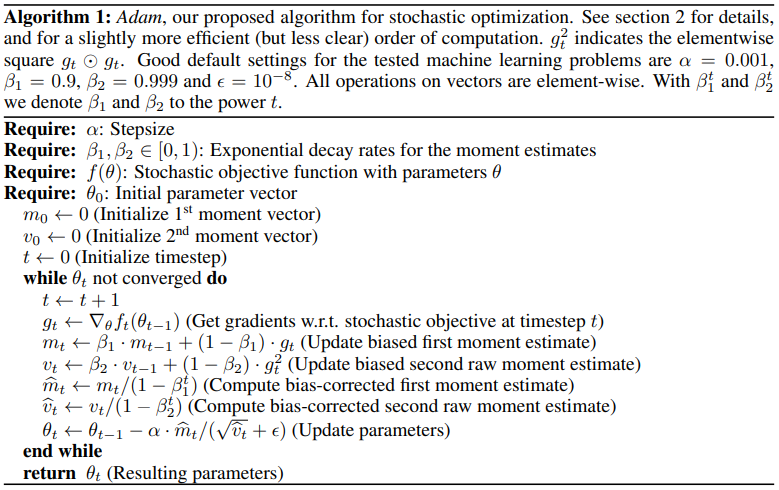
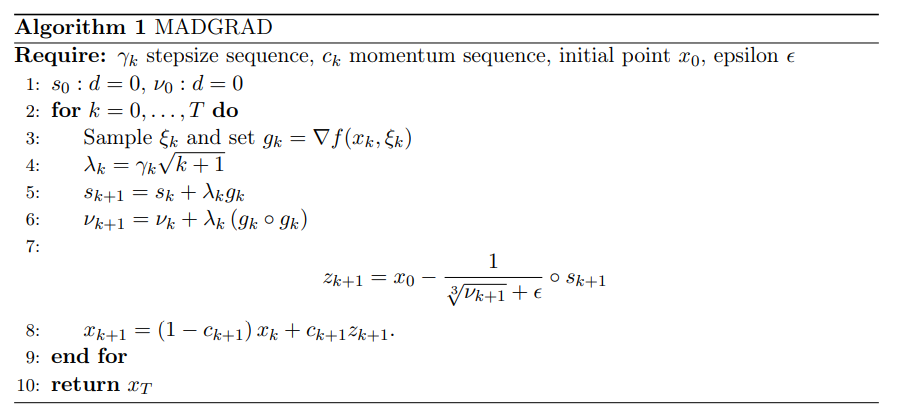

```python
class _DiagPowerEMA(Optimizer):
    """
    Generic diagonal-preconditioned momentum method:
      m_t = beta1 m_{t-1} + (1-beta1) g
      v_t = beta2 v_{t-1} + (1-beta2) g^2
      update = m_hat / (v_hat^power + eps)
    with decoupled weight decay (AdamW style) if weight_decay != 0.
    """
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        power: float = 0.5,   # Adam corresponds to power=0.5 (sqrt(v))
        eps=1e-8,
        weight_decay=0.0,
    ):
        defaults = dict(lr=lr, betas=betas, power=power, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["betas"]
            power = group["power"]
            eps = group["eps"]
            wd = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad

                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)

                state["step"] += 1
                t = state["step"]

                # decoupled WD
                if wd != 0.0:
                    p.mul_(1.0 - lr * wd)

                m = state["exp_avg"]
                v = state["exp_avg_sq"]

                m.mul_(beta1).add_(g, alpha=1.0 - beta1)
                v.mul_(beta2).addcmul_(g, g, value=1.0 - beta2)

                # bias correction (kept to match repo tuning style)
                m_hat = m / (1.0 - beta1 ** t)
                v_hat = v / (1.0 - beta2 ** t)

                denom = v_hat.pow(power).add_(eps)
                p.addcdiv_(m_hat, denom, value=-lr)

        return loss


class Adam(_DiagPowerEMA):
    """Adam (Table 1): D_t = (EMA[g^2])^{1/4} => denom uses v^{1/2} => power=0.5"""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        super().__init__(params, lr=lr, betas=betas, power=0.5, eps=eps, weight_decay=weight_decay)


class MADGRAD(_DiagPowerEMA):
    """MADGRAD (Table 1 parameterization): D_t = (EMA[g^2])^{1/6} => denom uses v^{1/3} => power=1/3"""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        super().__init__(params, lr=lr, betas=betas, power=(1.0 / 3.0), eps=eps, weight_decay=weight_decay)
```

### 2.5. SOAP
SOAP is "Shampoo in the optimizer state + Adam in the rotated basis":
1. Use Shampoo-style second-moment matrices (one per tensor dimension) to learn an orthogonal basis $Q$ that approximately diagonalizes gradient second moments per layer (or per tensor mode).
2. Project gradients into that basis (a “rotated coordinate system”).
3. In the rotated system, run Adam (elementwise preconditioning by $1/\sqrt v$ on the projected gradient.
4. Project the Adam-preconditioned direction back to the original parameter space and apply the update.
5. Update the Shampoo statistics and periodically refresh the bases $Q$

Shampoo captures correlations across coordinates, Adam captures coordinatewise scaling. SOAP uses Shampoo to pick a basis where the gradient covariance is closer to diagonal, making Adam’s diagonal preconditioner more effective and stable.

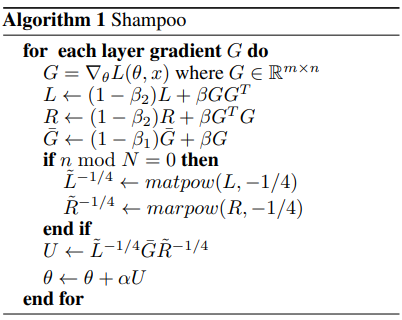

**Pseudocode summary**
```
if first time:
    init m=0, v=0
    init GG stats and Q basis
    update GG and Q using current grad
    skip update

else:
    # 1) rotate gradient
    g̃ = Project(g, Q)

    # 2) Adam in rotated space
    m = β1 m + (1-β1) g̃
    v = β2 v + (1-β2) g̃^2
    ũ = m / (sqrt(v) + eps)
    apply bias correction to lr if enabled

    # 3) rotate back and update params
    u = ProjectBack(ũ, Q)
    if normalize_grads: u = u / rms(u)
    W ← W − lr * u
    W ← W − lr * wd * W         (decoupled weight decay)

    # 4) update Shampoo stats and refresh Q occasionally
    GG ← EMA(GG, outer_products(g))
    if step % precond_freq == 0: refresh Q via 1 power iter + QR

```

### 2.6. SPlus
SPlus combines Shampoo-style eigenbases learned from gradient convariance (left/right factors) and a LMO for an $\ell_\infty$-type update, which in the rotated coordinates becomes the sign direction. Conceptually, it is a Frank–Wolfe / conditional gradient step in a geometry where picked basis is more diagonal (via Shampoo covariances) and choose to update direction by solving $S'_t\in\arg\min_{\Vert S'\Vert_\infty\leq1}\langle G_t',S'\rangle$ whose solution is $S'=-\text{sign}(G')$.
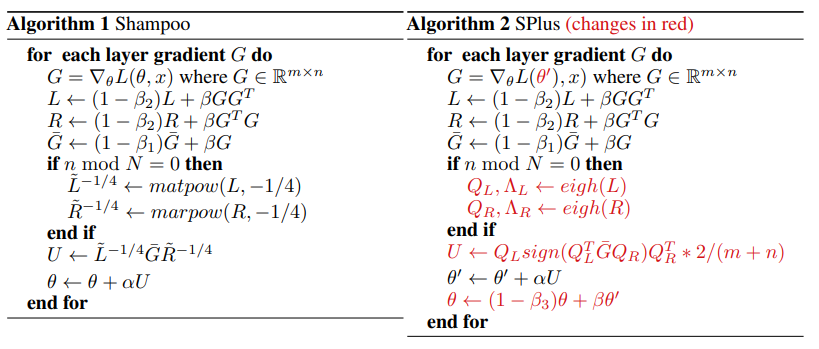

```python
class SPlus(_KroneckerBase):
    """
    SPlus: Q_L, Q_R eigenbases from Shampoo covariances; base norm l1 -> linf (sign).
    We implement 2D only:
      - maintain A = sum/EMA(GG^T), B = sum/EMA(G^T G)
      - compute eigenvectors QL, QR at update_freq
      - project: G' = QL^T G QR
      - sign LMO: S' = -sign(G')
      - unproject: S = QL S' QR^T
      - update: W <- W + lr * S   (S already includes descent sign)
    """
    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        any_fallback = False

        for group in self.param_groups:
            lr = group["lr"]
            wd = group["weight_decay"]
            eps = group["eps"]
            beta = group["beta"]
            update_freq = max(1, int(group["update_freq"]))

            for p in group["params"]:
                if p.grad is None:
                    continue
                if not self._should_matrix(p, group):
                    any_fallback = True
                    continue

                Gm, shp = _as_matrix(p.grad)
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    m, n = Gm.shape
                    state["A"] = torch.zeros((m, m), device=Gm.device, dtype=Gm.dtype)
                    state["B"] = torch.zeros((n, n), device=Gm.device, dtype=Gm.dtype)
                    state["QL"] = torch.eye(m, device=Gm.device, dtype=Gm.dtype)
                    state["QR"] = torch.eye(n, device=Gm.device, dtype=Gm.dtype)

                state["step"] += 1
                t = state["step"]

                if wd != 0.0:
                    p.mul_(1.0 - lr * wd)

                A = state["A"]
                B = state["B"]
                outerA = Gm @ Gm.T
                outerB = Gm.T @ Gm
                if beta is not None and beta >= 0.0:
                    A.lerp_(outerA, 1.0 - beta)
                    B.lerp_(outerB, 1.0 - beta)
                else:
                    A.add_(outerA)
                    B.add_(outerB)

                if (t % update_freq) == 0:
                    # eigenbases
                    wL, QL = torch.linalg.eigh(0.5 * (A + A.T))
                    wR, QR = torch.linalg.eigh(0.5 * (B + B.T))
                    state["QL"] = QL
                    state["QR"] = QR

                QL = state["QL"]
                QR = state["QR"]

                Gp = (QL.T @ Gm) @ QR
                Sp = lmo.sign_lmo(Gp)  # already descent
                S = (QL @ Sp) @ (QR.T)
                S = _restore_shape(S, shp)
                p.add_(S, alpha=lr)

        if any_fallback:
            self._fallback_step()

        return loss
```

### 2.7. MuAdam
MuAdam’s key idea is to combine Adam’s diagonal adaptivity with a spectral-norm constrained,  and matrix-aware update direction (Muon). Concretely, for each matrix weight $W$:
1. Use Adam to estimate a good gradient signal, providing denoising via $M_t$ and per-coordinate scaling via $V_t$
2. Precondition once to build a matrix $N_t$, which is Adam-style normalization, but with an exponent $p$ chosen so that applying it twice (before and after the spectral step) gives the desired overall scaling.
3. Apply a spectral-norm LMO step: keep directions, discard magnitudes, representing the steepest descent direction under a spectral-norm constraint (the LMO over the spectral-norm ball). It makes the step:
   - matrix-aware (acts on singular directions, not coordinates),
   - scale-invariant (singular values are removed),
   - stable (step magnitude controlled in operator norm).
4. Precondition again to reintroduce Adam’s diagonal geometry, ensuring the final update still respects Adam’s per-coordinate adaptivity, while the direction was chosen by the spectral LMO.

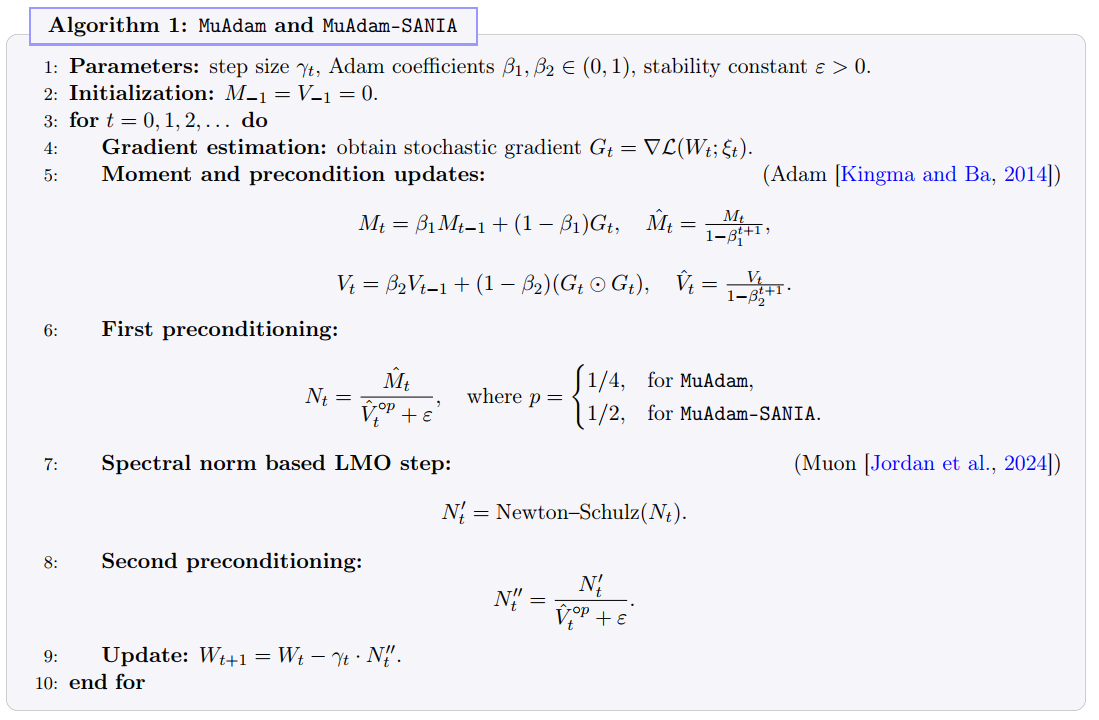